# Enron Dataset - Supervised Machine Learning

## Project Overview
In 2000, Enron was one of the largest companies in the United States. By 2002, it had collapsed into bankruptcy due to widespread corporate fraud. In the resulting Federal investigation, a significant amount of typically confidential information entered into the public record, including tens of thousands of emails and detailed financial data for top executives. In this project, you will play detective, and put your new skills to use by building a person of interest identifier based on financial and email data made public as a result of the Enron scandal. To assist you in your detective work, we've combined this data with a hand-generated list of persons of interest in the fraud case, which means individuals who were indicted, reached a settlement or plea deal with the government, or testified in exchange for prosecution immunity.

In [1]:
import sys
import pickle
sys.path.append("../tools/")

from feature_format import featureFormat, targetFeatureSplit
from tester import dump_classifier_and_data

### Task 1: Select what features you'll use.
### features_list is a list of strings, each of which is a feature name.
### The first feature must be "poi".

features_list = ['poi','salary','bonus']# You will need to use more features

### Load the dictionary containing the dataset
with open("final_project_dataset.pkl", "r") as data_file:
    data_dict = pickle.load(data_file)

/Users/nonusingh/anaconda/envs/python27/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## Data Exploration

In [2]:
#  What is the length of the dataset?
print "length of the dataset:"
print len(data_dict)

#  What is the Number of features in the dict?
unique_features = set(
    feature
    for row_dict in data_dict.values()
    for feature in row_dict.keys()
)
print "############################################"
print "number of unique features:"
print(len(unique_features))
print(unique_features)

# How many POIs in the dataset? How many are not POIs
count = 0
for user in data_dict:
    if data_dict[user]['poi'] == True:
        count+=1
print "############################################"
print "number of employees that are 'persons of interest':"
print (count)
print "############################################"
print "number of employees that are not POI:"
print len(data_dict)-(count)

length of the dataset:
146
############################################
number of unique features:
21
set(['salary', 'to_messages', 'deferral_payments', 'total_payments', 'loan_advances', 'bonus', 'email_address', 'restricted_stock_deferred', 'total_stock_value', 'shared_receipt_with_poi', 'long_term_incentive', 'exercised_stock_options', 'from_messages', 'other', 'from_poi_to_this_person', 'from_this_person_to_poi', 'poi', 'deferred_income', 'expenses', 'restricted_stock', 'director_fees'])
############################################
number of employees that are 'persons of interest':
18
############################################
number of employees that are not POI:
128


As seen above, There are 146 rows in the dataset with 21 unique features including financial features like 'salary', 'bonus', 'total_stock_value' and email related features like 'shared_receipt_with_poi', 'from_messages'. 
Out of the 146 employees, only 18 were POIs and rest(128) are not POI.

## Data Cleaning
Next, we will investigate outliers and try to remove them. There were a few outliers in the dataset for eg 'TOTAL' which had bonus: $10,529,459 as seen from the plot below. This was actually the total bonus of all the employees. Since it can skew the algorithm, I will delete this row. Another candidate is THE TRAVEL AGENCY IN THE PARK which is not a person but an agency. After removing the row, our dataset now has 145 rows

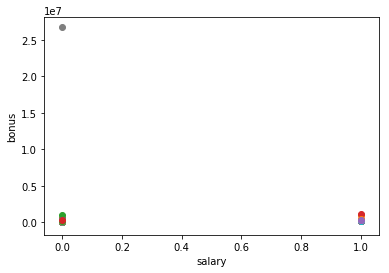

length of the dataset:
145


In [3]:
### Task 2: Remove outliers
import matplotlib.pyplot
data = featureFormat(data_dict, features_list)
for point in data:
    salary = point[0]
    bonus = point[1]
    matplotlib.pyplot.scatter( salary, bonus )
matplotlib.pyplot.xlabel("salary")
matplotlib.pyplot.ylabel("bonus")
matplotlib.pyplot.show()

# How to handle outlier with 1e7 bonus?
data_dict.pop('TOTAL', 0)

#  What is the length of the dataset now?
print "length of the dataset:"
print len(data_dict)

We will also investigate missing values for all features. Features with maximum rows with missing values are 'loan_advances'(142), 'director_fees'(129), 'restricted_stock_deferred'(128) , 'deferral_payments'(107), 'deferred_income'(97), and hence we will try to not include these features in our algorithm.

In [4]:
# How many features have most missing values?
missing_features = {}
for feature in unique_features:
    missing_count = 0
    for k in data_dict.iterkeys():
        if data_dict[k][feature] == "NaN":
            missing_count += 1
    missing_features[feature] = missing_count
print missing_features

{'salary': 51, 'to_messages': 59, 'deferral_payments': 107, 'total_payments': 21, 'exercised_stock_options': 44, 'bonus': 64, 'restricted_stock': 36, 'restricted_stock_deferred': 128, 'deferred_income': 97, 'total_stock_value': 20, 'shared_receipt_with_poi': 59, 'loan_advances': 142, 'from_messages': 59, 'other': 53, 'from_this_person_to_poi': 59, 'poi': 0, 'director_fees': 129, 'long_term_incentive': 80, 'expenses': 51, 'email_address': 34, 'from_poi_to_this_person': 59}


## Feature Selection 

In this section, we will create new features and find out important features in our data set.

In [5]:
### Task 3: Create new feature(s)
# New Feature: from_poi and to_poi
for employee in data_dict:
    if (data_dict[employee]['from_messages'] not in ['NaN', 0]) and (data_dict[employee]['from_this_person_to_poi'] not in ['NaN', 0]):
        data_dict[employee]['to_poi'] = float(data_dict[employee]['from_messages'])/float(data_dict[employee]['from_this_person_to_poi'])
    else:
        data_dict[employee]['to_poi'] = 0
        
for employee in data_dict:
    if (data_dict[employee]['to_messages'] not in ['NaN', 0]) and (data_dict[employee]['from_poi_to_this_person'] not in ['NaN', 0]):
        data_dict[employee]['from_poi'] = float(data_dict[employee]['to_messages'])/float(data_dict[employee]['from_poi_to_this_person'])
    else:
        data_dict[employee]['from_poi'] = 0

I created two new features:'to_poi' is the fraction of messages sent to POIs out of the total sent messages(from_messages/from_this_person_to_poi) and the feature 'from_poi' is the fraction of messages received from POIs out of total received messages(to_messages/from_poi_to_this_person) for each employee. If a person has been communicating with POI a lot, it could mean he/she is also a POI. Smaller value of to_poi and from_poi would mean more communication and hence higher probability of being a POI himself/herself. Next, lets evaluate if including these two parameters improve the accuracy of our predictions

In [6]:
### Store to my_dataset for easy export below.
my_dataset = data_dict
features_list = ['poi','salary','to_messages', 'deferral_payments',
                'total_payments','exercised_stock_options','bonus','restricted_stock',
                'shared_receipt_with_poi','total_stock_value','expenses','from_messages',
                'other','from_this_person_to_poi','deferred_income','long_term_incentive',
                'from_poi_to_this_person','restricted_stock_deferred','loan_advances','director_fees']

### Does the new feature improve the accuracy of our predictions?
features_list1 = ['poi','salary','to_messages', 'deferral_payments',
                'total_payments','exercised_stock_options','bonus','restricted_stock',
                'shared_receipt_with_poi','total_stock_value','expenses','from_messages',
                'other','from_this_person_to_poi','deferred_income','long_term_incentive',
                'from_poi_to_this_person','restricted_stock_deferred','loan_advances','director_fees']

features_list2 = ['poi','salary','to_messages', 'deferral_payments',
                'total_payments','exercised_stock_options','bonus','restricted_stock',
                'shared_receipt_with_poi','total_stock_value','expenses','from_messages',
                'other','from_this_person_to_poi','deferred_income','long_term_incentive',
                'from_poi_to_this_person','restricted_stock_deferred','loan_advances',
                'director_fees','from_poi','to_poi']

from sklearn.naive_bayes import GaussianNB
gnb_clf = GaussianNB()

### Extract features and labels from dataset for local testing
data1 = featureFormat(my_dataset, features_list1, sort_keys = True)
labels1, features1 = targetFeatureSplit(data1)
data2 = featureFormat(my_dataset, features_list2, sort_keys = True)
labels2, features2 = targetFeatureSplit(data2)

gnb_clf.fit(features1, labels1)
print "Accuracy without new features:", gnb_clf.score(features1, labels1)
gnb_clf.fit(features2, labels2)
print "Accuracy with new features:", gnb_clf.score(features2, labels2)

Accuracy without new features: 0.826388888889
Accuracy with new features: 0.826388888889


I applied a simple Naive Bayes algorithm on the dataset to compare the accuracy with and without the added new features, but it was same. The new features had no impact on the accuracy of the algorithm(82.63% in both cases), Next we will see out of the total 23 features, which are the top most important features.

In [7]:
### Top important features
from sklearn.feature_selection import SelectKBest, f_classif
skb = SelectKBest()
selected_features = skb.fit_transform(features2,labels2)
features_selected=[features_list2[i+1] for i in skb.get_support(indices=True)]
print "############################################"
print 'Features selected by SelectKBest:'
print features_selected

############################################
Features selected by SelectKBest:
['salary', 'total_payments', 'exercised_stock_options', 'bonus', 'restricted_stock', 'shared_receipt_with_poi', 'total_stock_value', 'deferred_income', 'long_term_incentive', 'loan_advances']


The top ten important features are: 'salary', 'total_payments', 'exercised_stock_options', 'bonus', 'restricted_stock', 'shared_receipt_with_poi', 'total_stock_value', 'deferred_income', 'long_term_incentive' and  'loan_advances'. The newly created features: 'from_poi' and 'to_poi' did not make it to the top 10 features.

Now, we identified a few features before that had too many missing values: 'loan_advances', 'director_fees', 'restricted_stock_deferred', 'deferral_payments', 'deferred_income', before but since select k best selected the 'loan_advances' and 'deferred_income', we need to be careful in selecting features. I want to check how many POIs have missing data for these 5 features before eliminating them. Since I have fewer POIs in our dataset

In [8]:
import pandas as pd
df = pd.DataFrame(my_dataset)
df = df.T
df.loc[df['poi'] == True][['loan_advances', 'director_fees', 'restricted_stock_deferred',
                           'deferral_payments', 'deferred_income']]

,loan_advances,director_fees,restricted_stock_deferred,deferral_payments,deferred_income
BELDEN TIMOTHY N,NaN,NaN,NaN,2144013,-2334434
BOWEN JR RAYMOND M,NaN,NaN,NaN,NaN,-833
CALGER CHRISTOPHER F,NaN,NaN,NaN,NaN,-262500
CAUSEY RICHARD A,NaN,NaN,NaN,NaN,-235000
COLWELL WESLEY,NaN,NaN,NaN,27610,-144062
DELAINEY DAVID W,NaN,NaN,NaN,NaN,NaN
FASTOW ANDREW S,NaN,NaN,NaN,NaN,-1386055
GLISAN JR BEN F,NaN,NaN,NaN,NaN,NaN
HANNON KEVIN P,NaN,NaN,NaN,NaN,-3117011
HIRKO JOSEPH,NaN,NaN,NaN,10259,NaN


I filtered for all the POIs to see if any of them had any values for the features we intend to remove from my algorithm.'loan advances', 'deferral_payments' and 'deferred_income' have values in them and hence if we remove these features, I will lose information pertinent to POIs. I am safe to remove director_fees and restricted_stock_deferred from the algorithm. I also removed email_address feature as its not numerical.

### Pick and Tune an Algorithm

Next we try a variety of supervised machine learning classifiers to make predictions and test their accuracy. 

In [9]:
## Task 4: Try a varity of classifiers
### Please name your classifier clf for easy export below.
### Note that if you want to do PCA or other multi-stage operations,
### you'll need to use Pipelines. For more info:
### http://scikit-learn.org/stable/modules/pipeline.html

from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest
from sklearn import cross_validation
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import AdaBoostClassifier
from sklearn.decomposition import PCA

features_list = ['poi','salary','to_messages', 'deferral_payments',
                'total_payments','exercised_stock_options','bonus','restricted_stock',
                'shared_receipt_with_poi','total_stock_value','expenses',
                'other','from_this_person_to_poi','deferred_income','long_term_incentive',
                'from_poi_to_this_person','loan_advances']

data = featureFormat(my_dataset, features_list, sort_keys = True)
labels, features = targetFeatureSplit(data)

from sklearn.cross_validation import train_test_split
features_train, features_test, labels_train, labels_test = \
    train_test_split(features, labels, test_size=0.3, random_state=42)
    
sss = StratifiedShuffleSplit(n_splits= 100, test_size= 0.3, random_state= 42)
sss.get_n_splits(features, labels)

## Gaussian Classifier
from sklearn.naive_bayes import GaussianNB
g_clf = GaussianNB()
g_clf.fit(features_train, labels_train)
g_pred = g_clf.predict(features_test)

### Adaboost Classifier
from sklearn.ensemble import AdaBoostClassifier
a_clf = AdaBoostClassifier(random_state=42)
a_clf.fit(features_train, labels_train)
a_pred = a_clf.predict(features_test)

### Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier
r_clf = RandomForestClassifier(random_state=42)
r_clf.fit(features_train, labels_train)
r_pred = r_clf.predict(features_test)

### Decision Tree Classifier
from sklearn.tree import DecisionTreeClassifier
dt_clf = DecisionTreeClassifier(random_state=42)
dt_clf.fit(features_train, labels_train)
dt_pred = dt_clf.predict(features_test)

## Evaluate Initial Classifiers
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

print "############################################"
print "Precision score_Gaussian is:", precision_score(labels_test, g_pred)
print "Recall score_Gaussian is: ", recall_score(labels_test, g_pred)
print "############################################"
print "Precision score_Adaboost is:", precision_score(labels_test, a_pred)
print "Recall score_Adaboost is: ", recall_score(labels_test, a_pred)
print "############################################"
print "Precision score_RandomForest is:", precision_score(labels_test, r_pred)
print "Recall score_RandomForest is: ", recall_score(labels_test, r_pred)
print "############################################"
print "Precision score_DecisionTree is:", precision_score(labels_test, dt_pred)
print "Recall score_DecisionTree is: ", recall_score(labels_test, dt_pred)
print "############################################"

############################################
Precision score_Gaussian is: 0.4
Recall score_Gaussian is:  0.4
############################################
Precision score_Adaboost is: 0.333333333333
Recall score_Adaboost is:  0.4
############################################
Precision score_RandomForest is: 0.0
Recall score_RandomForest is:  0.0
############################################
Precision score_DecisionTree is: 0.0
Recall score_DecisionTree is:  0.0
############################################


I picked Naive Bayes because it gave me the best Precision and Recall of 0.4 and 0.4. Given the limited dataset, it makes sense that the simplest algorithm gave the best results. Hence the algorithm of choice would be Naive Bayes.

### Class Imbalance
Most machine learning algorithms and works best when the number of instances of each classes are roughly equal. In our dataset, only 18 out of 146 employees are POI. Since we have less number of POI, machine learning will tend to classify all employees as non POI and will still give fairly good accuracy. 

This problem in machine learning where the total number of a class of data (positive) is far less than the total number of another class of data (negative) is called class imbalance. This problem is extremely common in practice and can be observed in various disciplines including fraud detection, anomaly detection, medical diagnosis, oil spillage detection, facial recognition, etc.[Ref8] We need to reduce false negatives that our algorithm predicts which would be POIs that were falsely classified as non POI.
Precision is Proportion of all employees classified POIs that are correct. Recall is Proportion of all real POIs that are correctly classified.

## Tuning the Algorithm
We will now tune the algorithm and optimize the parameters of the algorithm to enable best performance. The most common way of tuning has been grid search, or a parameter sweep, which is simply an exhaustive searching through a manually specified subset of the hyperparameters. A grid search algorithm must be guided by some performance metric, typically measured by cross-validation on the training set or evaluation on a held-out validation set[Ref7]. 

I used pipeline to do multiple functions sequentially. I first performed feature scaling using min max scalar as PCA needs normalized data[Ref1], then applied PCA for dimensionality reduction based on percent variation explained and then applied select k best to choose from 1,2,3 or 4 best principal components using grid search. I used grid search to tune number of components of PCA(based on percent variation) and selection of k best features

In [10]:
### Task 5: Tune your classifier to achieve better than .3 precision and recall 
### using our testing script. Check the tester.py script in the final project
### folder for details on the evaluation method, especially the test_classifier
### function. Because of the small size of the dataset, the script uses
### stratified shuffle split cross validation. For more info: 
### http://scikit-learn.org/stable/modules/generated/sklearn.cross_validation.StratifiedShuffleSplit.html
# Example starting point. Try investigating other evaluation techniques!

features_list = ['poi','salary','to_messages', 'loan_advances', 'deferral_payments',
                'total_payments','exercised_stock_options','bonus','restricted_stock',
                'shared_receipt_with_poi','total_stock_value','expenses','from_messages',
                'other','from_this_person_to_poi','deferred_income','long_term_incentive',
                'from_poi_to_this_person']

sss = StratifiedShuffleSplit(n_splits= 100, test_size= 0.3, random_state= 42)
scaler = MinMaxScaler()
pca = PCA()

clf = GaussianNB()    # Provided to give you a starting point. Try a varity of classifiers.
pipe = Pipeline(steps=[('scaler', scaler),('pca', pca),('skb', skb), ('gaussian', clf)])

params = dict(pca__n_components=[4,5,6,7,8,9,10],
                    skb__k = [1,2,3,4])

gs = GridSearchCV(pipe, params, cv=sss, scoring = 'f1')

StratifiedShuffleSplit returns test and train splits which are created by preserving the same percentage for each target class as in the complete set. I used 30% of my data for test split and rest for training. StratifiedShuffleSplit is useful where the data is imbalanced. 

In [11]:
##########
# Output
########## 

gs.fit(features_train, labels_train)
print "############################################"
print("Best estimator:")
print(gs.best_estimator_)
print("Best score:")
print(gs.best_score_)
print("Best parameters:")
print(gs.best_params_)
print "############################################"
print ' '


clf = gs.best_estimator_
clf.fit(features_train, labels_train)

pred = clf.predict(features_test)

/Users/nonusingh/anaconda/envs/python27/lib/python2.7/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


############################################
Best estimator:
Pipeline(steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('pca', PCA(copy=True, iterated_power='auto', n_components=10, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('skb', SelectKBest(k=2, score_func=<function f_classif at 0x11a41e668>)), ('gaussian', GaussianNB(priors=None))])
Best score:
0.325090909091
Best parameters:
{'pca__n_components': 10, 'skb__k': 2}
############################################
 


GridSearch selected 10 Principal components as best parameters and skb selected 2 best features as the best parameters for our algorithm

In [17]:
pca.fit(features)
print pca.explained_variance_ratio_.cumsum()

[ 0.81249011  0.96098139  0.9758785   0.98967482  0.99423658  0.99686645
  0.99848469  0.99925697  0.99986357  0.99994662  0.99999124  0.99999998
  1.          1.          1.          1.        ]


the top 10 PCA components explain 99.994662% of variation

## Validation

In [14]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

print "############################################"
print "Precision score is:", precision_score(labels_test, pred)
print "Recall score is: ", recall_score(labels_test, pred)
print "############################################"
print "Classification Report:\n ", classification_report(labels_test, pred)
print "############################################"
print "Confusion Matrix:\n ", confusion_matrix(labels_test, pred)
print "############################################"

############################################
Precision score is: 0.5
Recall score is:  0.6
############################################
Classification Report:
               precision    recall  f1-score   support

        0.0       0.95      0.92      0.94        39
        1.0       0.50      0.60      0.55         5

avg / total       0.90      0.89      0.89        44

############################################
Confusion Matrix:
  [[36  3]
 [ 2  3]]
############################################


After Tuning, the Precision and Recall have improved to 0.5 and 0.6!

### What is Precision and Recall?

Due to imbalanced dataset, along with the accuracy of the algorithm, we need to make sure the POIs are correctly identified as POIs. It is easy to label all employees as not POI and still have a decent accuracy score. The validation metric that tells how many POIs were correctly identified is Recall. It is ratio of correctly classified POIs to all POIs- those that were correctly classified and those which were misclassified as Non POI

  $Recall = \frac{Correctly\ Classified\ POIs}{Real\ POIs}$


Precision score on the other hand is to check that employees classified as POI are real POIs. To do that, we calculate precision of the algorithm. Precision is the ratio of correctly classified POIs and Total employees classified as POI. It tells us out of all the employees we suspected as POIs, how many are really POIs 

  $Precision = \frac{Correctly\ Classified\ POIs}{Classified\ POIs}$


Larger precision score means algorithm has reduced false positives which are employees that are not POIs but are classified as POIs. In a case of scam, it is very important as you we don't want to send the wrong person to jail.
Larger recall score means algorithm has reduced false negatives which are POIs that are wrongly classified as non POIs.

In a classification task, a precision score of 1.0 for a class C means that every item labeled as belonging to class C does indeed belong to class C (but says nothing about the number of items from class C that were not labeled correctly) whereas a recall of 1.0 means that every item from class C was labeled as belonging to class C (but says nothing about how many other items were incorrectly also labeled as belonging to class C).[Ref3]

For this problem, a good recall score means we have identified POIs correctly and a good precision score means POIs we classified are in fact POIs.

#### ...in the context of the project

The average precision for my decision tree classifier was 0.5 and the average recall was 0.6. What do each of these mean?

 - Precision is how often our class prediction (POI vs. non-POI) is right when we guess that class
 - Recall is how often we guess the class (POI vs. non-POI) when the class actually occurred

In the context of our POI identifier, it is arguably more important to make sure we don't miss any POIs, so we don't care so much about precision. Imagine we are law enforcement using this algorithm as a screener to determine who to prosecute. When we guess POI, it is not the end of the world if they aren't a POI because we'll do due diligence. We won't put them in jail right away. For our case, we want high recall: when it is a POI, we need to make sure we catch them in our net. The Naive Bayes algorithm performed best in recall (0.6) of the algorithms I tried, hence it being my choice for final analysis.

In [15]:
### Task 6: Dump your classifier, dataset, and features_list so anyone can
### check your results. You do not need to change anything below, but make sure
### that the version of poi_id.py that you submit can be run on its own and
### generates the necessary .pkl files for validating your results.

dump_classifier_and_data(clf, my_dataset, features_list)

## Testing

In [16]:
# %load tester.py
#!/usr/bin/pickle

""" a basic script for importing student's POI identifier,
    and checking the results that they get from it 
 
    requires that the algorithm, dataset, and features list
    be written to my_classifier.pkl, my_dataset.pkl, and
    my_feature_list.pkl, respectively

    that process should happen at the end of poi_id.py
"""

import pickle
import sys
from sklearn.cross_validation import StratifiedShuffleSplit
sys.path.append("../tools/")
from feature_format import featureFormat, targetFeatureSplit

PERF_FORMAT_STRING = "\
\tAccuracy: {:>0.{display_precision}f}\tPrecision: {:>0.{display_precision}f}\t\
Recall: {:>0.{display_precision}f}\tF1: {:>0.{display_precision}f}\tF2: {:>0.{display_precision}f}"
RESULTS_FORMAT_STRING = "\tTotal predictions: {:4d}\tTrue positives: {:4d}\tFalse positives: {:4d}\
\tFalse negatives: {:4d}\tTrue negatives: {:4d}"

def test_classifier(clf, dataset, feature_list, folds = 1000):
    data = featureFormat(dataset, feature_list, sort_keys = True)
    labels, features = targetFeatureSplit(data)
    cv = StratifiedShuffleSplit(labels, folds, random_state = 42)
    true_negatives = 0
    false_negatives = 0
    true_positives = 0
    false_positives = 0
    for train_idx, test_idx in cv: 
        features_train = []
        features_test  = []
        labels_train   = []
        labels_test    = []
        for ii in train_idx:
            features_train.append( features[ii] )
            labels_train.append( labels[ii] )
        for jj in test_idx:
            features_test.append( features[jj] )
            labels_test.append( labels[jj] )
        
        ### fit the classifier using training set, and test on test set
        clf.fit(features_train, labels_train)
        predictions = clf.predict(features_test)
        for prediction, truth in zip(predictions, labels_test):
            if prediction == 0 and truth == 0:
                true_negatives += 1
            elif prediction == 0 and truth == 1:
                false_negatives += 1
            elif prediction == 1 and truth == 0:
                false_positives += 1
            elif prediction == 1 and truth == 1:
                true_positives += 1
            else:
                print "Warning: Found a predicted label not == 0 or 1."
                print "All predictions should take value 0 or 1."
                print "Evaluating performance for processed predictions:"
                break
    try:
        total_predictions = true_negatives + false_negatives + false_positives + true_positives
        accuracy = 1.0*(true_positives + true_negatives)/total_predictions
        precision = 1.0*true_positives/(true_positives+false_positives)
        recall = 1.0*true_positives/(true_positives+false_negatives)
        f1 = 2.0 * true_positives/(2*true_positives + false_positives+false_negatives)
        f2 = (1+2.0*2.0) * precision*recall/(4*precision + recall)
        print clf
        print PERF_FORMAT_STRING.format(accuracy, precision, recall, f1, f2, display_precision = 5)
        print RESULTS_FORMAT_STRING.format(total_predictions, true_positives, false_positives, false_negatives, true_negatives)
        print ""
    except:
        print "Got a divide by zero when trying out:", clf
        print "Precision or recall may be undefined due to a lack of true positive predicitons."

CLF_PICKLE_FILENAME = "my_classifier.pkl"
DATASET_PICKLE_FILENAME = "my_dataset.pkl"
FEATURE_LIST_FILENAME = "my_feature_list.pkl"

def dump_classifier_and_data(clf, dataset, feature_list):
    with open(CLF_PICKLE_FILENAME, "w") as clf_outfile:
        pickle.dump(clf, clf_outfile)
    with open(DATASET_PICKLE_FILENAME, "w") as dataset_outfile:
        pickle.dump(dataset, dataset_outfile)
    with open(FEATURE_LIST_FILENAME, "w") as featurelist_outfile:
        pickle.dump(feature_list, featurelist_outfile)

def load_classifier_and_data():
    with open(CLF_PICKLE_FILENAME, "r") as clf_infile:
        clf = pickle.load(clf_infile)
    with open(DATASET_PICKLE_FILENAME, "r") as dataset_infile:
        dataset = pickle.load(dataset_infile)
    with open(FEATURE_LIST_FILENAME, "r") as featurelist_infile:
        feature_list = pickle.load(featurelist_infile)
    return clf, dataset, feature_list

def main():
    ### load up student's classifier, dataset, and feature_list
    clf, dataset, feature_list = load_classifier_and_data()
    ### Run testing script
    test_classifier(clf, dataset, feature_list)

if __name__ == '__main__':
    main()


Pipeline(steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('pca', PCA(copy=True, iterated_power='auto', n_components=10, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('skb', SelectKBest(k=2, score_func=<function f_classif at 0x11a41e668>)), ('gaussian', GaussianNB(priors=None))])
	Accuracy: 0.86233	Precision: 0.47584	Recall: 0.32000	F1: 0.38266	F2: 0.34243
	Total predictions: 15000	True positives:  640	False positives:  705	False negatives: 1360	True negatives: 12295



Verified with tester that Precision and Recall is greater than 0.3

*Ques1:* Summarize for us the goal of this project and how machine learning is useful in trying to accomplish it. As part of your answer, give some background on the dataset and how it can be used to answer the project question. Were there any outliers in the data when you got it, and how did you handle those?  [relevant rubric items: “data exploration”, “outlier investigation”]

*Ans1:* The goal of this project is to detect persons of interest involved in Enron scandal using machine learning. Enron data provided as a part of this project had features like salary drawn, emails, stock options, bonus etc. The idea here is that the emails exchange and financial information of the employees can provide valuable insight into their involvement(or lack of) in the scandal. Our goal is to identify those employees(POI or persons of interest) using supervised machine learning techniques. There were a few outliers in the dataset for eg 'TOTAL' which had salary: $10,529,459. This was actually the total of all the rows and needed to be excluded so I removed it using data_dict.pop()Another candidate is THE TRAVEL AGENCY IN THE PARK which is not a person but an agency, but since the agency can also be a part of the fraud, I did not remove it.


*Ques2:* What features did you end up using in your POI identifier, and what selection process did you use to pick them? Did you have to do any scaling? Why or why not? As part of the assignment, you should attempt to engineer your own feature that does not come ready-made in the dataset -- explain what feature you tried to make, and the rationale behind it. (You do not necessarily have to use it in the final analysis, only engineer and test it.) In your feature selection step, if you used an algorithm like a decision tree, please also give the feature importances of the features that you use, and if you used an automated feature selection function like SelectKBest, please report the feature scores and reasons for your choice of parameter values.  [relevant rubric items: “create new features”, “intelligently select features”, “properly scale features”]

*Ans2:* I used Select k best for picking top important features. I created my own feature:'from_poi' which was fraction of emails sent to poi. It was not the top 10 features picked by the slect k best algorithm and it did not improve my accuracy. My top selected financial features: 'salary', 'total_payments', 'exercised_stock_options', 'bonus', 'restricted_stock','total_stock_value', 'expenses', 'deferred_income', 'long_term_incentive'. The only non financial feature that was important was: 'shared_receipt_with_poi'. Select k best picked 10 best features by default. In my pipeline, I used gridsearch to find the best k for the algorithm.
I also used feature scaling using min max scalar. I intended to use PCA  for dimensionality reduction and PCA requires normalized data.[Ref1]. My pipeline consisted of PCA, Select k best, and then Naive Bayes classifier. Since I used PCA first, I reduced the dimension to 4 and hence select k best chose from 1,2,3,4 best features of PCA.


*Ques3:* What algorithm did you end up using? What other one(s) did you try? How did model performance differ between algorithms?  [relevant rubric item: “pick an algorithm”]
What does it mean to tune the parameters of an algorithm, and what can happen if you don’t do this well?  How did you tune the parameters of your particular algorithm? What parameters did you tune? (Some algorithms do not have parameters that you need to tune -- if this is the case for the one you picked, identify and briefly explain how you would have done it for the model that was not your final choice or a different model that does utilize parameter tuning, e.g. a decision tree classifier).  [relevant rubric items: “discuss parameter tuning”, “tune the algorithm”]

*Ans3:* I tried variety of algorithms and although I wanted Adaboost to work the best due to unbalanced nature of my data set, the simplest algorithm- Naive Bayes gave me the best precision and recall. I used grid search to tune number of components of PCA(based on percent variation) and selection of k best features which improved my precision and recall from 0.4 and 0.4 to 0.5 and 0.6 respectively. I did not have parameters of Naive Bayes to tune so I just tuned PCA and k best. Tuning of the algorithm means altering the model according to the problem at hand. If you do not tune the algorithm properly, you can end up over or under fitting your data and your predictions will have less accuracy. My second best choice was adaboost for which I could tune: learning rate, n_estimators, algorithm(‘SAMME’/‘SAMME.R’)


*Ques4:* What is validation, and what’s a classic mistake you can make if you do it wrong? How did you validate your analysis?  [relevant rubric items: “discuss validation”, “validation strategy”]
Give at least 2 evaluation metrics and your average performance for each of them.  Explain an interpretation of your metrics that says something human-understandable about your algorithm’s performance. [relevant rubric item: “usage of evaluation metrics”]

*Ans4:* Learning the parameters of a prediction function and testing it on the same data is a common methodological mistake: a model that would just repeat the labels of the samples that it has just seen would have a perfect score but would fail to predict anything useful on yet-unseen data(Overfitting)[Ref2]. To avoid this, we hold out part of the available data as a test set and then cross validate it against the labels of the test set. I validated my algorithm using StratifiedShuffleSplit. StratifiedShuffleSplit returns test and train splits which are created by preserving the same percentage for each target class as in the complete set.
The evaluation metrics that I used were: precision, recall and f1.
The precision is the ratio tp / (tp + fp) where tp is the number of true positives and fp the number of false positives. The precision is intuitively the ability of the classifier not to label as positive a sample that is negative.[Ref3] The precision of our tuned model was 0.5
The recall is the ratio tp / (tp + fn) where tp is the number of true positives and fn the number of false negatives. The recall is intuitively the ability of the classifier to find all the positive samples.[Ref3] Recall of our tuned model was 0.6
The F-1 score can be interpreted as a weighted harmonic mean of the precision and recall, where an F-beta score reaches its best value at 1 and worst score at 0.[Ref3]

### References


Ref 1: http://scikit-learn.org/stable/auto_examples/preprocessing/plot_scaling_importance.html

Ref 2: http://scikit-learn.org/stable/modules/cross_validation.html

Ref 3: http://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_recall_fscore_support.html

Ref 4: http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html

Ref 5: https://discussions.udacity.com/t/starting-the-final-project/179090/4

Ref 6: http://scikit-learn.org/stable/modules/naive_bayes.html

Ref 7: https://en.wikipedia.org/wiki/Hyperparameter_(machine_learning)

Ref 8: http://www.chioka.in/class-imbalance-problem/